# Production Technology

The dataset contains `N = 441` firms observed over `T = 12` years, 1968-1979. There variables are: 
* `lcap`: Log of capital stock, $k_{it}$ 
* `lemp`: log of employment, $\ell_{it}$ 
* `ldsa`: log of deflated sales, $y_{it}$
* `year`: the calendar year of the observation, `year` $ = 1968, ..., 1979$, 
* `firmid`: anonymized indicator variable for the firm, $i = 1, ..., N$, with $N=441$. 

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns
import os
print(os.listdir())
import project_1 as est
from numpy import linalg as la
from scipy.stats import chi2
from scipy import stats
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

['2025-09_Project_1.pdf', 'firms.csv', 'project_1.py', 'read (1).ipynb', '__pycache__']


In [3]:
dat = pd.read_csv('firms.csv')

# Descriptives

In [4]:
dat.describe()

,firmid,year,lcap,lemp,ldsa
count,5292.000000,5292.000000,5.292000e+03,5.292000e+03,5.292000e+03
mean,221.000000,1973.500000,-7.125472e-09,-1.252834e-08,4.695767e-09
std,127.317437,3.452379,1.310973e+00,1.180122e+00,1.232499e+00
min,1.000000,1968.000000,-3.864950e+00,-3.382780e+00,-3.551540e+00
25%,111.000000,1970.750000,-9.083267e-01,-7.855270e-01,-9.279720e-01
50%,221.000000,1973.500000,-1.180615e-01,-1.137295e-01,-1.029710e-01
75%,331.000000,1976.250000,9.063340e-01,7.930060e-01,8.562296e-01
max,441.000000,1979.000000,4.103687e+00,3.371332e+00,3.913391e+00


In [5]:
#Descriptive statistics table
cols = ['lcap','lemp','ldsa']

tab = (
    dat[cols]
      .agg(['mean','kurt'])   # 'kurt' = excess kurtosis (normal = 0)
      .T
      .round(3)
      .rename(columns={'mean':'Mean', 'kurt':'Kurtosis'})
)

latex = tab.to_latex(
    index=True,
    caption='Beskrivende statistik (samlet): middelværdi og kurtosis',
    label='tab:desc_overall',
    float_format="%.3f",
    escape=False
)

print(latex)

\begin{table}
\caption{Beskrivende statistik (samlet): middelværdi og kurtosis}
\label{tab:desc_overall}
\begin{tabular}{lrr}
\toprule
 & Mean & Kurtosis \\
\midrule
lcap & -0.000 & -0.133 \\
lemp & -0.000 & -0.190 \\
ldsa & 0.000 & -0.260 \\
\bottomrule
\end{tabular}
\end{table}



In [6]:
# De-log-transform variables 
dat['cap'] = np.exp(dat['lcap'])
dat['emp'] = np.exp(dat['lemp'])
dat['dsa'] = np.exp(dat['ldsa'])

cols = ['cap','emp','dsa']

tab = (
    dat[cols]
      .agg(['mean','kurt'])   # 'kurt' = excess kurtosis (normal = 0)
      .T
      .round(3)
      .rename(columns={'mean':'Mean', 'kurt':'Kurtosis'})
)

latex = tab.to_latex(
    index=True,
    caption='Beskrivende statistik (samlet): middelværdi og kurtosis',
    label='tab:desc_overall',
    float_format="%.3f",
    escape=False
)

print(latex)

\begin{table}
\caption{Beskrivende statistik (samlet): middelværdi og kurtosis}
\label{tab:desc_overall}
\begin{tabular}{lrr}
\toprule
 & Mean & Kurtosis \\
\midrule
cap & 2.524 & 41.329 \\
emp & 2.058 & 15.489 \\
dsa & 2.233 & 28.024 \\
\bottomrule
\end{tabular}
\end{table}



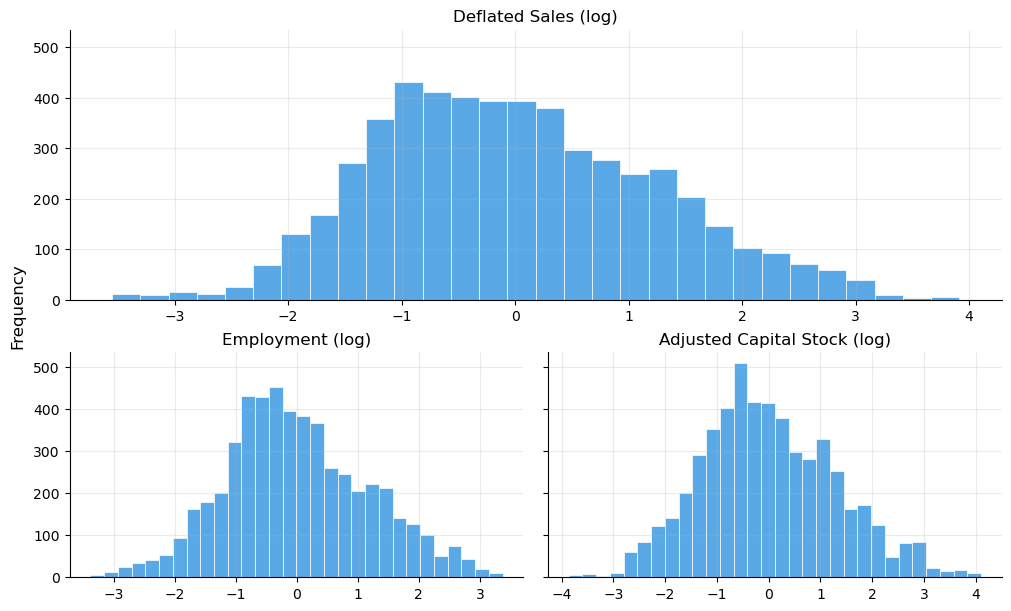

In [7]:
blue = "#5aa9e6"  # lys blå

fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=2, height_ratios=[1.2, 1.0])

ax_top = fig.add_subplot(gs[0, :])                 # øverste (salg), span begge kolonner
ax_bl  = fig.add_subplot(gs[1, 0], sharey=ax_top)  # nederst venstre, deler y med top
ax_br  = fig.add_subplot(gs[1, 1], sharey=ax_top)  # nederst højre, deler y med top

# Øverst: Salg (centeret)
ax_top.hist(dat['ldsa'].dropna(), bins=30, color=blue, edgecolor="white", linewidth=0.5)
ax_top.set_title("Deflated Sales (log)", loc="center")

# Nederst venstre: Beskæftigelse
ax_bl.hist(dat['lemp'].dropna(), bins=30, color=blue, edgecolor="white", linewidth=0.5)
ax_bl.set_title("Employment (log)", loc="center")

# Nederst højre: Kapital
ax_br.hist(dat['lcap'].dropna(), bins=30, color=blue, edgecolor="white", linewidth=0.5)
ax_br.set_title("Adjusted Capital Stock (log)", loc="center")

# Fælles y-akse: kun én y-label på figuren
for ax in (ax_top, ax_bl, ax_br):
    ax.grid(True, alpha=0.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel("")              # ingen individuelle y-labels

fig.supylabel("Frequency")          # fælles y-label for alle paneler

# Skjul y-tick labels på højre nederste panel for mindre støj
ax_br.tick_params(labelleft=False)

# Ingen over-overskrift
try:
    fig._suptitle.remove()
except Exception:
    pass
plt.show()

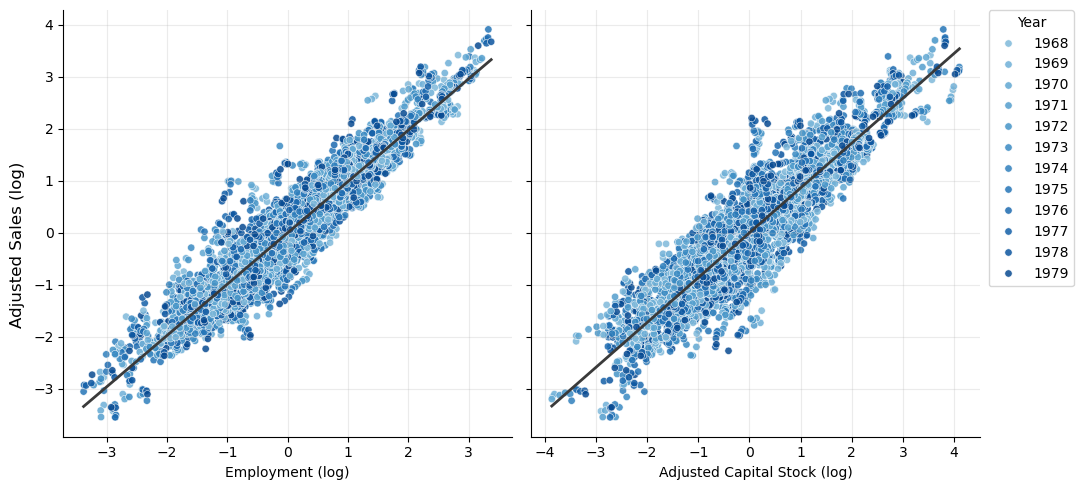

In [8]:
years = np.sort(dat['year'].unique())

# Blå palette: vælg et snævert interval af 'Blues' for harmoniske nuancer
cmap = plt.cm.Blues
colors = cmap(np.linspace(0.45, 0.90, len(years)))  # gør intervallet smallere/større efter smag
palette = {y: colors[i] for i, y in enumerate(years)}

fig, axes = plt.subplots(1, 2, figsize=(11, 5), sharey=True)

# Venstre: Employment (log) vs Adjusted Sales (log)
sns.scatterplot(
    x='lemp', y='ldsa', data=dat, ax=axes[0],
    hue='year', hue_order=years, palette=palette,
    edgecolor="white", s=28, alpha=0.85, legend=False
)
sns.regplot(
    x='lemp', y='ldsa', data=dat, ax=axes[0], scatter=False,
    color="#3a3a3a", ci=None, line_kws={'linewidth': 2}
)
axes[0].set_xlabel("Employment (log)")
axes[0].set_ylabel("")

# Højre: Capital (log) vs Adjusted Sales (log)
sns.scatterplot(
    x='lcap', y='ldsa', data=dat, ax=axes[1],
    hue='year', hue_order=years, palette=palette,
    edgecolor="white", s=28, alpha=0.85, legend=True
)
sns.regplot(
    x='lcap', y='ldsa', data=dat, ax=axes[1], scatter=False,
    color="#3a3a3a", ci=None, line_kws={'linewidth': 2}
)
axes[1].set_xlabel("Adjusted Capital Stock (log)")
axes[1].set_ylabel("")

# Kosmetik
for ax in axes:
    ax.grid(True, alpha=0.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    sns.despine(ax=ax)

fig.supylabel("Adjusted Sales (log)")
axes[1].legend(title="Year", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

try:
    fig._suptitle.remove()
except Exception:
    pass

plt.tight_layout()
plt.show()


# Converting data to numpy format 

In [9]:
dat.ldsa.values.shape

(5292,)

In [10]:
#Define N and T for our models 
N = dat.firmid.unique().size
T = dat.year.unique().size
assert dat.shape[0] == N*T, f'Error: data is not a balanced panel'
print(f'Data has N={N} and T={T}')

Data has N=441 and T=12


In [11]:
#Define sales as our dependent variable 
y = dat.ldsa.values.reshape((N*T,1))

#Laver et konstantled som repræsenterer det teknologiske niveau, A og definerer vores X matrix
ones = np.ones((N*T,1)) 
l = dat.lemp.values.reshape((N*T,1))
k = dat.lcap.values.reshape((N*T,1))
X = np.hstack([ones, l, k])
label_y = 'log_omsætning'
label_x = ['const', 'log_ansatte', 'log_kapital']

#Rename columns for easier reading
rename_dict = {'year': 'aar', 'ldsa':'log_omsætning', 'lemp': 'log_ansatte', 'lcap': 'log_kapital'}
dat = dat.rename(columns=rename_dict)

# OLS

In [12]:
#Estimerer pooled ols for benchmark 
pooled_result = est.estimate(y, X, T=T)
est.print_table((label_y, label_x), pooled_result, title='Pooled OLS regression', floatfmt='.4f')

Pooled OLS regression
Dependent variable: log_omsætning

               Beta      Se    t-values
-----------  ------  ------  ----------
const        0.0000  0.0050      0.0000
log_ansatte  0.6748  0.0102     66.4625
log_kapital  0.3100  0.0091     33.9237
R² = 0.914
σ² = 0.131


# FE

In [114]:
###Transform the data#####
# Create transformation matrix
Q_T = np.eye(T) - (np.ones((T,T)))/T
#Print dimension of Q_T
print(f'Dimension of Q_T: {Q_T.shape}')

#Create y and x dot using the perm function
y_dot = est.perm(Q_T, y.reshape(-1, 1))           # (N*T, 1)
x_dot = est.perm(Q_T, X)                           # (N*T, K)
x_dot = x_dot[:,1:]

# Estimate the fe model using the estimate function
label_x_fe = ['log_ansatte', 'log_kapital'] 
fe_result = est.estimate(y_dot, x_dot, robust_se=True, transform='fe', T=T)
est.print_table((label_y, label_x_fe), fe_result, title="Fixed Effects", floatfmt='.4f')

Dimension of Q_T: (12, 12)
Fixed Effects
Dependent variable: log_omsætning

               Beta      Se    t-values
-----------  ------  ------  ----------
log_ansatte  0.6942  0.0417     16.6674
log_kapital  0.1546  0.0299      5.1630
R² = 0.477
σ² = 0.018


# test af seriel korrelation i fejlled

In [69]:
def fd_matrix(T):
    D_T = np.zeros((T-1, T))
    for i in range (T-1):
        D_T[i,i] = -1
        D_T[i, i+1] = 1
    return D_T

# Print the matrix
D_T = fd_matrix(T)

# use dt til at lave first differences
y_diff = est.perm(D_T, y.reshape(-1, 1))           # (N*(T-1), 1)
x_diff = est.perm(D_T, X)                           # (N*(T-1, K)

#udvælg kolonner
x_diff = x_diff[:, 1:]  # drop constant column

# Estimate FE OLS using the demeaned variables.
fd_result = est.estimate(y_diff, x_diff, transform='fd', T=T)
label_x_fd = ['log_ansatte', 'log_kapital']

# Print results
est.print_table((label_y, label_x_fd), fd_result, title='FD regression', floatfmt='.4f')


FD regression
Dependent variable: log_omsætning

               Beta      Se    t-values
-----------  ------  ------  ----------
log_ansatte  0.5487  0.0183     29.9635
log_kapital  0.0630  0.0191      3.3043
R² = 0.165
σ² = 0.014


In [91]:
# Make function to calculate the serial correlation
def serial_corr(y, x, T):
    # Calculate the residuals
    if x.ndim == 1:
        x = x.reshape(-1, 1)     
    if y.ndim == 1:
        y = y.reshape(-1, 1)                     # sikr 2D
    b_hat = la.inv(x.T @ x) @ (x.T @ y)
    e = y - x @ b_hat                         # (N*T,)

    # Create a lag transformation matrix (perm to lag)
    # Picks [y1, y2, ..., y_{T-1}]
    P_lag = np.eye(T-1, T)                    # (T-1 x T)

    # Lag residuals panelvis
    E = e.reshape(-1, T)                      # (N, T)
    e_l = (E @ P_lag.T).reshape(-1, 1)        # (N*(T-1), 1)  ← regressor

    # Create a transformation matrix that removes the first time-period (perm to drop first)
    # Picks [y2, y3, ..., y_T]
    I_T = np.eye(T-1, T, k=1)                 # (T-1 x T)

    # Remove first observation of each individual (align "now" with the lag)
    e = (E @ I_T.T).reshape(-1,1)              # (N*(T-1),)    ← dependent var

    # Calculate the serial correlation (no intercept in FD)
    N = e.shape[0] // (T-1)
    return est.estimate(e, e_l, transform='fd', T=T-1)


In [99]:
# Estimate serial correlation
corr_result = serial_corr(y_diff, x_diff, T-1)
# Print results
label_ye = 'OLS residual, e\u1d62\u209c'
label_e = ['e\u1d62\u209c\u208B\u2081']
est.print_table(
    (label_ye, label_e), corr_result, 
    title='Serial Correlation', floatfmt='.4f'
)
# calculate p-value for test of no serial correlation
r = corr_result['b_hat'][0]
p_val = 2 * (1 - stats.norm.cdf(np.abs(r) / corr_result['se'][0]))
#p_val = float(p_val)
print(f'P-value for test of no serial correlation: {p_val[0]:8.4f}')


Serial Correlation
Dependent variable: OLS residual, eᵢₜ

          Beta      Se    t-values
-----  -------  ------  ----------
eᵢₜ₋₁  -0.1987  0.0148    -13.4493
R² = 0.039
σ² = 0.014
P-value for test of no serial correlation:   0.0000


# RE

In [16]:
############################### The between estimator ###############################   
#Calculate P_T
P_T = np.ones((1, T)) / T
#Print the shape of P_T
print(f'Dimension of P_T: {P_T.shape}')

y_mean = est.perm(P_T, y.reshape(-1, 1))   # (N*T,   )
x_mean = est.perm(P_T, X)           # (N*T, K )

#Estimate the between model using the estimate function
be_result = est.estimate(y_mean, x_mean, robust_se=True, transform='be', T=T)
est.print_table((label_y, label_x), be_result, title="Between Estimator", floatfmt='.4f')

Dimension of P_T: (1, 12)
Between Estimator
Dependent variable: log_omsætning

               Beta      Se    t-values
-----------  ------  ------  ----------
const        0.0000  0.0137      0.0000
log_ansatte  0.6672  0.0412     16.2107
log_kapital  0.3188  0.0349      9.1438
R² = 0.923
σ² = 0.115


In [17]:
############################## Calculate lambda ########################
sigma2_u = fe_result['sigma2']
sigma2_w = float(((u := (np.asarray(y_mean).reshape(-1,1) - np.asarray(x_mean) @ np.asarray(be_result['b_hat']).reshape(-1,1))).T @ u) / (np.asarray(x_mean).shape[0] - np.asarray(x_mean).shape[1]))
sigma2_c = sigma2_w - (sigma2_u / T)
_lambda = 1 - np.sqrt(sigma2_u / (T * sigma2_c + sigma2_u))

# Print lambda 
print(f'Lambda is approximately equal to {_lambda.item():.4f}.')

Lambda is approximately equal to 0.8873.


/var/folders/yb/2nwpczt56kvbrmb8klk29wfw0000gn/T/ipykernel_4667/924895852.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma2_w = float(((u := (np.asarray(y_mean).reshape(-1,1) - np.asarray(x_mean) @ np.asarray(be_result['b_hat']).reshape(-1,1))).T @ u) / (np.asarray(x_mean).shape[0] - np.asarray(x_mean).shape[1]))


In [19]:
############################### Estimate RE model ###############################
# # Create the identity matrix with dimension T
I_T = np.eye(T)
#Create C_T using I_T and P_T
C_T = I_T - _lambda @ P_T
#Transform y and x using perm function
y_re = est.perm(C_T, y.reshape(-1, 1))           # (N*T, 1)
x_re = est.perm(C_T, X)                           # (N*T, K)

# Estimate 
re_result = est.estimate(y_re, x_re, robust_se=True, transform='re', T=T)
est.print_table((label_y, label_x), re_result, title="Random Effects", floatfmt='.4f')

Random Effects
Dependent variable: log_omsætning

               Beta      Se    t-values
-----------  ------  ------  ----------
const        0.0000  0.0168      0.0000
log_ansatte  0.7197  0.0335     21.4644
log_kapital  0.1989  0.0261      7.6177
R² = 0.642
σ² = 0.018


## Hausmann 

In [ ]:
# Unpack the betas 
b_fe = fe_result['b_hat']
b_re = re_result['b_hat']
cov_fe = fe_result['cov']
cov_re = re_result['cov']

b_diff = b_fe - b_re
cov_diff = cov_fe - cov_re
H = b_diff.T @ la.inv(cov_diff) @ b_diff

# Find critical value and p-value at 5% significance level of chi^2 with M degrees of freedom
M = len(b_fe)
crit_val = chi2.ppf(0.95, df=M)
p_val = 1 - chi2.cdf(H, df=M)


# Print the results
print(f'The test statistic is {H.item():.2f}.')
print(f'The critical value at a 5% significance level is {crit_val:.2f}.')
print(f"The p-value is {float(np.asarray(p_val).reshape(-1)[0]):.8f}.")

The test statistic is 10.36.
The critical value at a 5% significance level is 7.81.
The p-value is 0.01576505.


Vi aviser at RE og FE er ens, hvilket indikerer korrelation mellem A og kapital,employees 

E

## Test for strict exo 

In [23]:
#Add a lead of the emp variable,
# Create F_T to shift the emp variable one period forward
F_T = np.eye(T, T, k=1)
# Create emp_lead_full using perm function
emp_lead_full = est.perm(F_T, X[:, 2].reshape(-1, 1)) # the shape is (N*T, 1)
# Remove the last observed year for every individual
I_T = np.eye(T-1, T)
# Remove the last observations
x_exo = est.perm(I_T, X)                       # (N*(T-1), K)
y_exo = est.perm(I_T, y.reshape(-1, 1))        # (N*(T-1), 1)
emp_lead = est.perm(I_T, emp_lead_full)             # (N*(T-1), 1)
assert x_exo.shape[0] == emp_lead.shape[0] == y_exo.shape[0]

In [39]:
# Add union_lead to x_exo
x_exo = np.hstack((x_exo, emp_lead))                 # (N*(T-1), K+1)

# Within transform the data (demean over T-1)
Tm1 = T - 1
Q_T = np.eye(Tm1) - np.ones((Tm1, Tm1)) / Tm1          # (T-1)×(T-1)

# apply panel-wise with your perm helper
yw_exo = est.perm(Q_T, y_exo.reshape(-1, 1)).reshape(-1,)   # (N*(T-1),)
xw_exo = est.perm(Q_T, x_exo)                               # (N*(T-1), K+1)

# Select variables (employement, capital stock, emp_lead)
xw_exo = np.hstack((xw_exo[:, 1:3], xw_exo[:, -1].reshape(-1, 1)))


In [40]:
xw_exo

array([[ 0.05583273,  0.10680513,  0.02605548],
       [ 0.05673973,  0.03341733, -0.01954212],
       [ 0.03288373, -0.01218027, -0.05606072],
       ...,
       [ 0.42175355,  0.28885009,  0.36140027],
       [ 0.52469655,  0.46101609,  0.54379327],
       [ 0.57336755,  0.64340909,  0.55805127]], shape=(4851, 3))

In [42]:
# Estimate model
yw_exo = yw_exo.reshape(-1, 1)
exo_test = est.estimate(yw_exo, xw_exo, transform='fe', T=T-1)

# Print results
label_exo = ['emp'] + ['cap'] + ['emp lead']
est.print_table((label_y, label_exo), exo_test, title='Exogeneity test', floatfmt='.4f')


Exogeneity test
Dependent variable: log_omsætning

            Beta      Se    t-values
--------  ------  ------  ----------
emp       0.6479  0.0162     39.9359
cap       0.0210  0.0231      0.9093
emp lead  0.1793  0.0258      6.9500
R² = 0.474
σ² = 0.016


In [58]:
#Test if variable 5 is significant different from 0
from scipy import stats
b = exo_test['b_hat']
cov = exo_test['cov']
se = np.sqrt(np.diag(cov))
t_stat = b[2] / se[2]
# frihedsgrader (hvis ikke df_resid findes, så udled dem)
df = exo_test.get('df_resid', len(yw_exo) - len(b))
p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=3))
p_value = float(p_value)  # or p_value = p_value.item()
print(f'Test statistic for H0: beta_3 = 0 is {t_stat} with p-value {p_value:8.4f}')  

                

Test statistic for H0: beta_3 = 0 is [6.95000331] with p-value   0.0061


C:\Users\annal\AppData\Local\Temp\ipykernel_5828\532724668.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p_value = float(p_value)  # or p_value = p_value.item()


## Hypothesis test

In [ ]:
b_hat = fe_result['b_hat']
cov   = fe_result['cov']

ansatte_index = label_x.index('log_ansatte')
kapital_index = label_x.index('log_kapital')

# Gør vektorer/matricer klar
b = np.asarray(b_hat).reshape(-1)   # (P,)
V = np.asarray(cov)                 # (P,P)
P = b.size
if V.shape != (P, P):
    raise ValueError(f"Kovarians har forkert form: {V.shape}, forventede {(P,P)}")

# Byg R (1 x P) med 1 på de to relevante koefficienter
R = np.zeros((1, P))
R[0, [ansatte_index, kapital_index]] = 1.0

# Wald-test for H0: beta_kapital + beta_ansatte = 1
num = float(R @ b - 1.0)           # c'β - q, q=1
den = float(R @ V @ R.T)           # c' V c
if not np.isfinite(den) or den <= 0:
    raise ValueError("Variansen af restriktionen er ikke positiv/finitsk; tjek kovarians og indeks.")

wald = (num ** 2) / den
p_value = stats.chi2.sf(wald, df=1)

print(f"Wald test statistic: {wald:.4f}")
print(f"p-value: {p_value:.4g}")

Wald test statistic: 19.4029
p-value: 1.058e-05


/var/folders/yb/2nwpczt56kvbrmb8klk29wfw0000gn/T/ipykernel_4667/3841634096.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  num = float(R @ b - 1.0)           # c'β - q, q=1
/var/folders/yb/2nwpczt56kvbrmb8klk29wfw0000gn/T/ipykernel_4667/3841634096.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  den = float(R @ V @ R.T)           # c' V c


Vi afviser klart og tydeligt H0 i FE modellen. Altså der er ikke constant return to scale i data givet at FE-modellen er sand. 